**Code to extract features and train models to classify text messages into spam/ham, Used NLTK and DNN models**

BASE IMPORTS

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Load dataset folder and files

In [27]:
# CODE FOR READING DATA FROM DOODLE DRIVE IN COLLAB  
'''
from google.colab import drive
drive.mount('/content/drive/')
!pwd
!ls
data = pd.read_csv('/content/drive/MyDrive/NLP_datasets/spam.csv').rename(columns={'sms':'text'})
data['text_length'] = data['text'].apply(lambda x: len(x.split()))
data.head()
'''
# CODE FOR READING DATA FROM LOCAL DRIVE
data = pd.read_csv('dataset/spam.csv').rename(columns={'sms':'text'})
data['text_length'] = data['text'].apply(lambda x: len(x.split()))
data.head()

text  label  text_length
0  Go until jurong point, crazy.. Available only ...      0           20
1                    Ok lar... Joking wif u oni...\n      0            6
2  Free entry in 2 a wkly comp to win FA Cup fina...      1           28
3  U dun say so early hor... U c already then say...      0           11
4  Nah I don't think he goes to usf, he lives aro...      0           13

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         5574 non-null   object
 1   label        5574 non-null   int64 
 2   text_length  5574 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 130.8+ KB


In [29]:
data.isna().sum()

text           0
label          0
text_length    0
dtype: int64

**Some visualizations of the dataset**

In [30]:
colour_palette = sns.color_palette("Reds_r", 2)

Plotting the distributions of the label to see how well the labels are distributed for training the model eventually

Text(0, 0.5, 'Count')

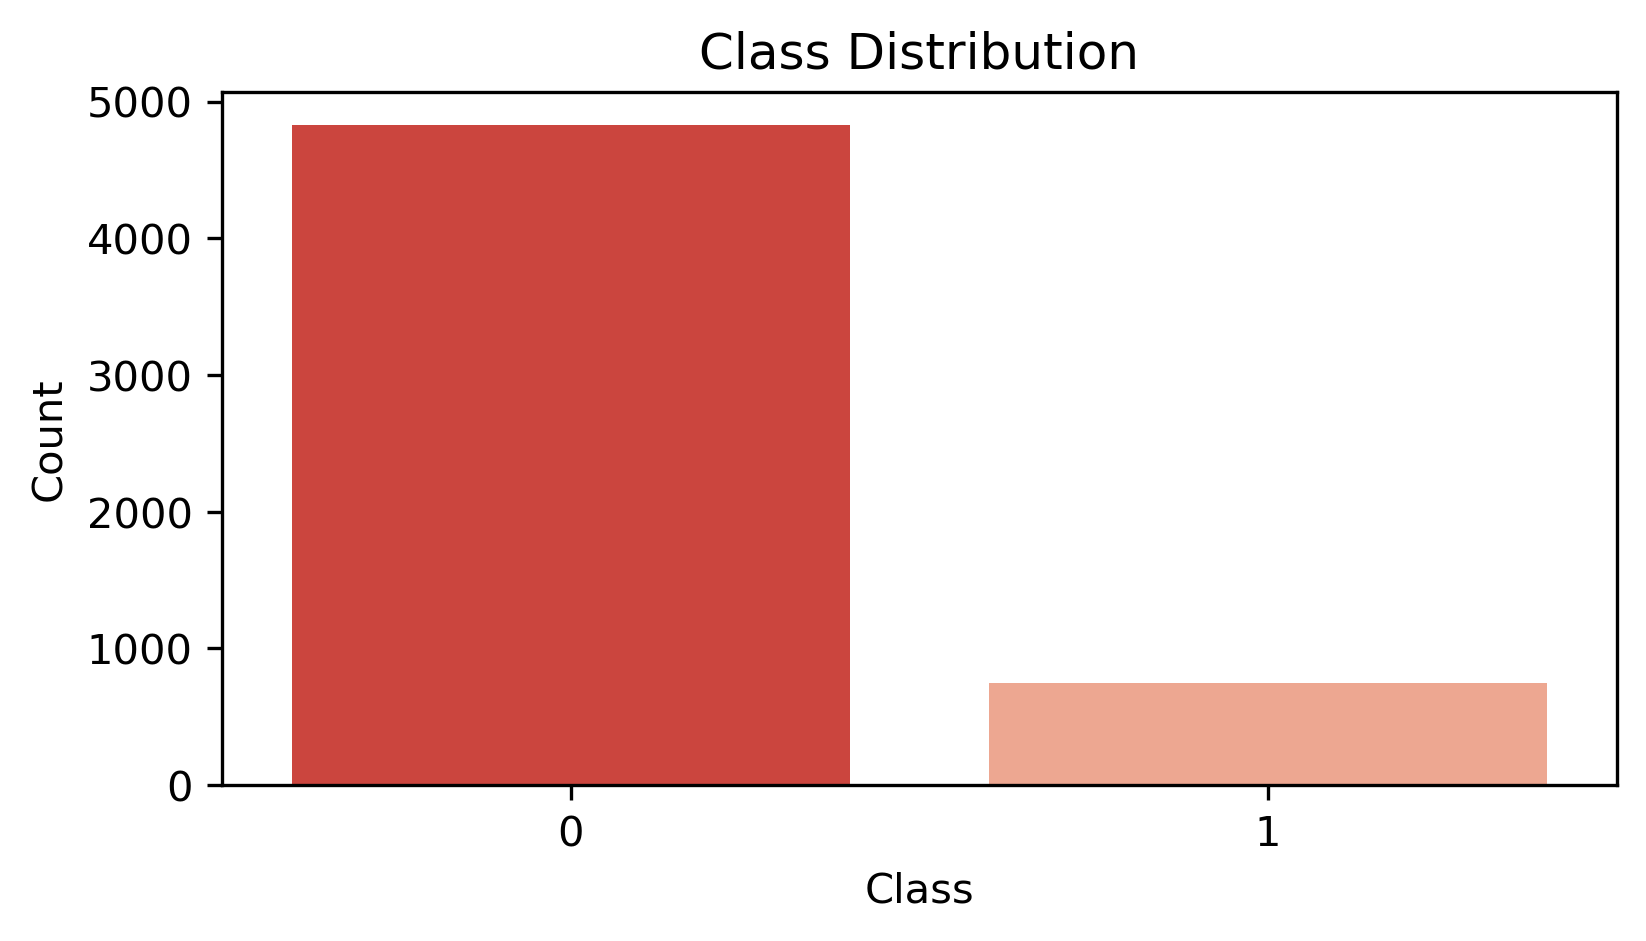

In [31]:
plt.figure(figsize=(6, 3), dpi=300)
sns.set_palette(colour_palette)
sns.countplot(x='label', data=data)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

Plotting the distribution of the text length with respect to the labels

/home/anshu/anaconda3/envs/nlp/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/anshu/anaconda3/envs/nlp/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/anshu/anaconda3/envs/nlp/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/anshu/anaconda3/envs/nlp/lib/python3.9/site-packages/s

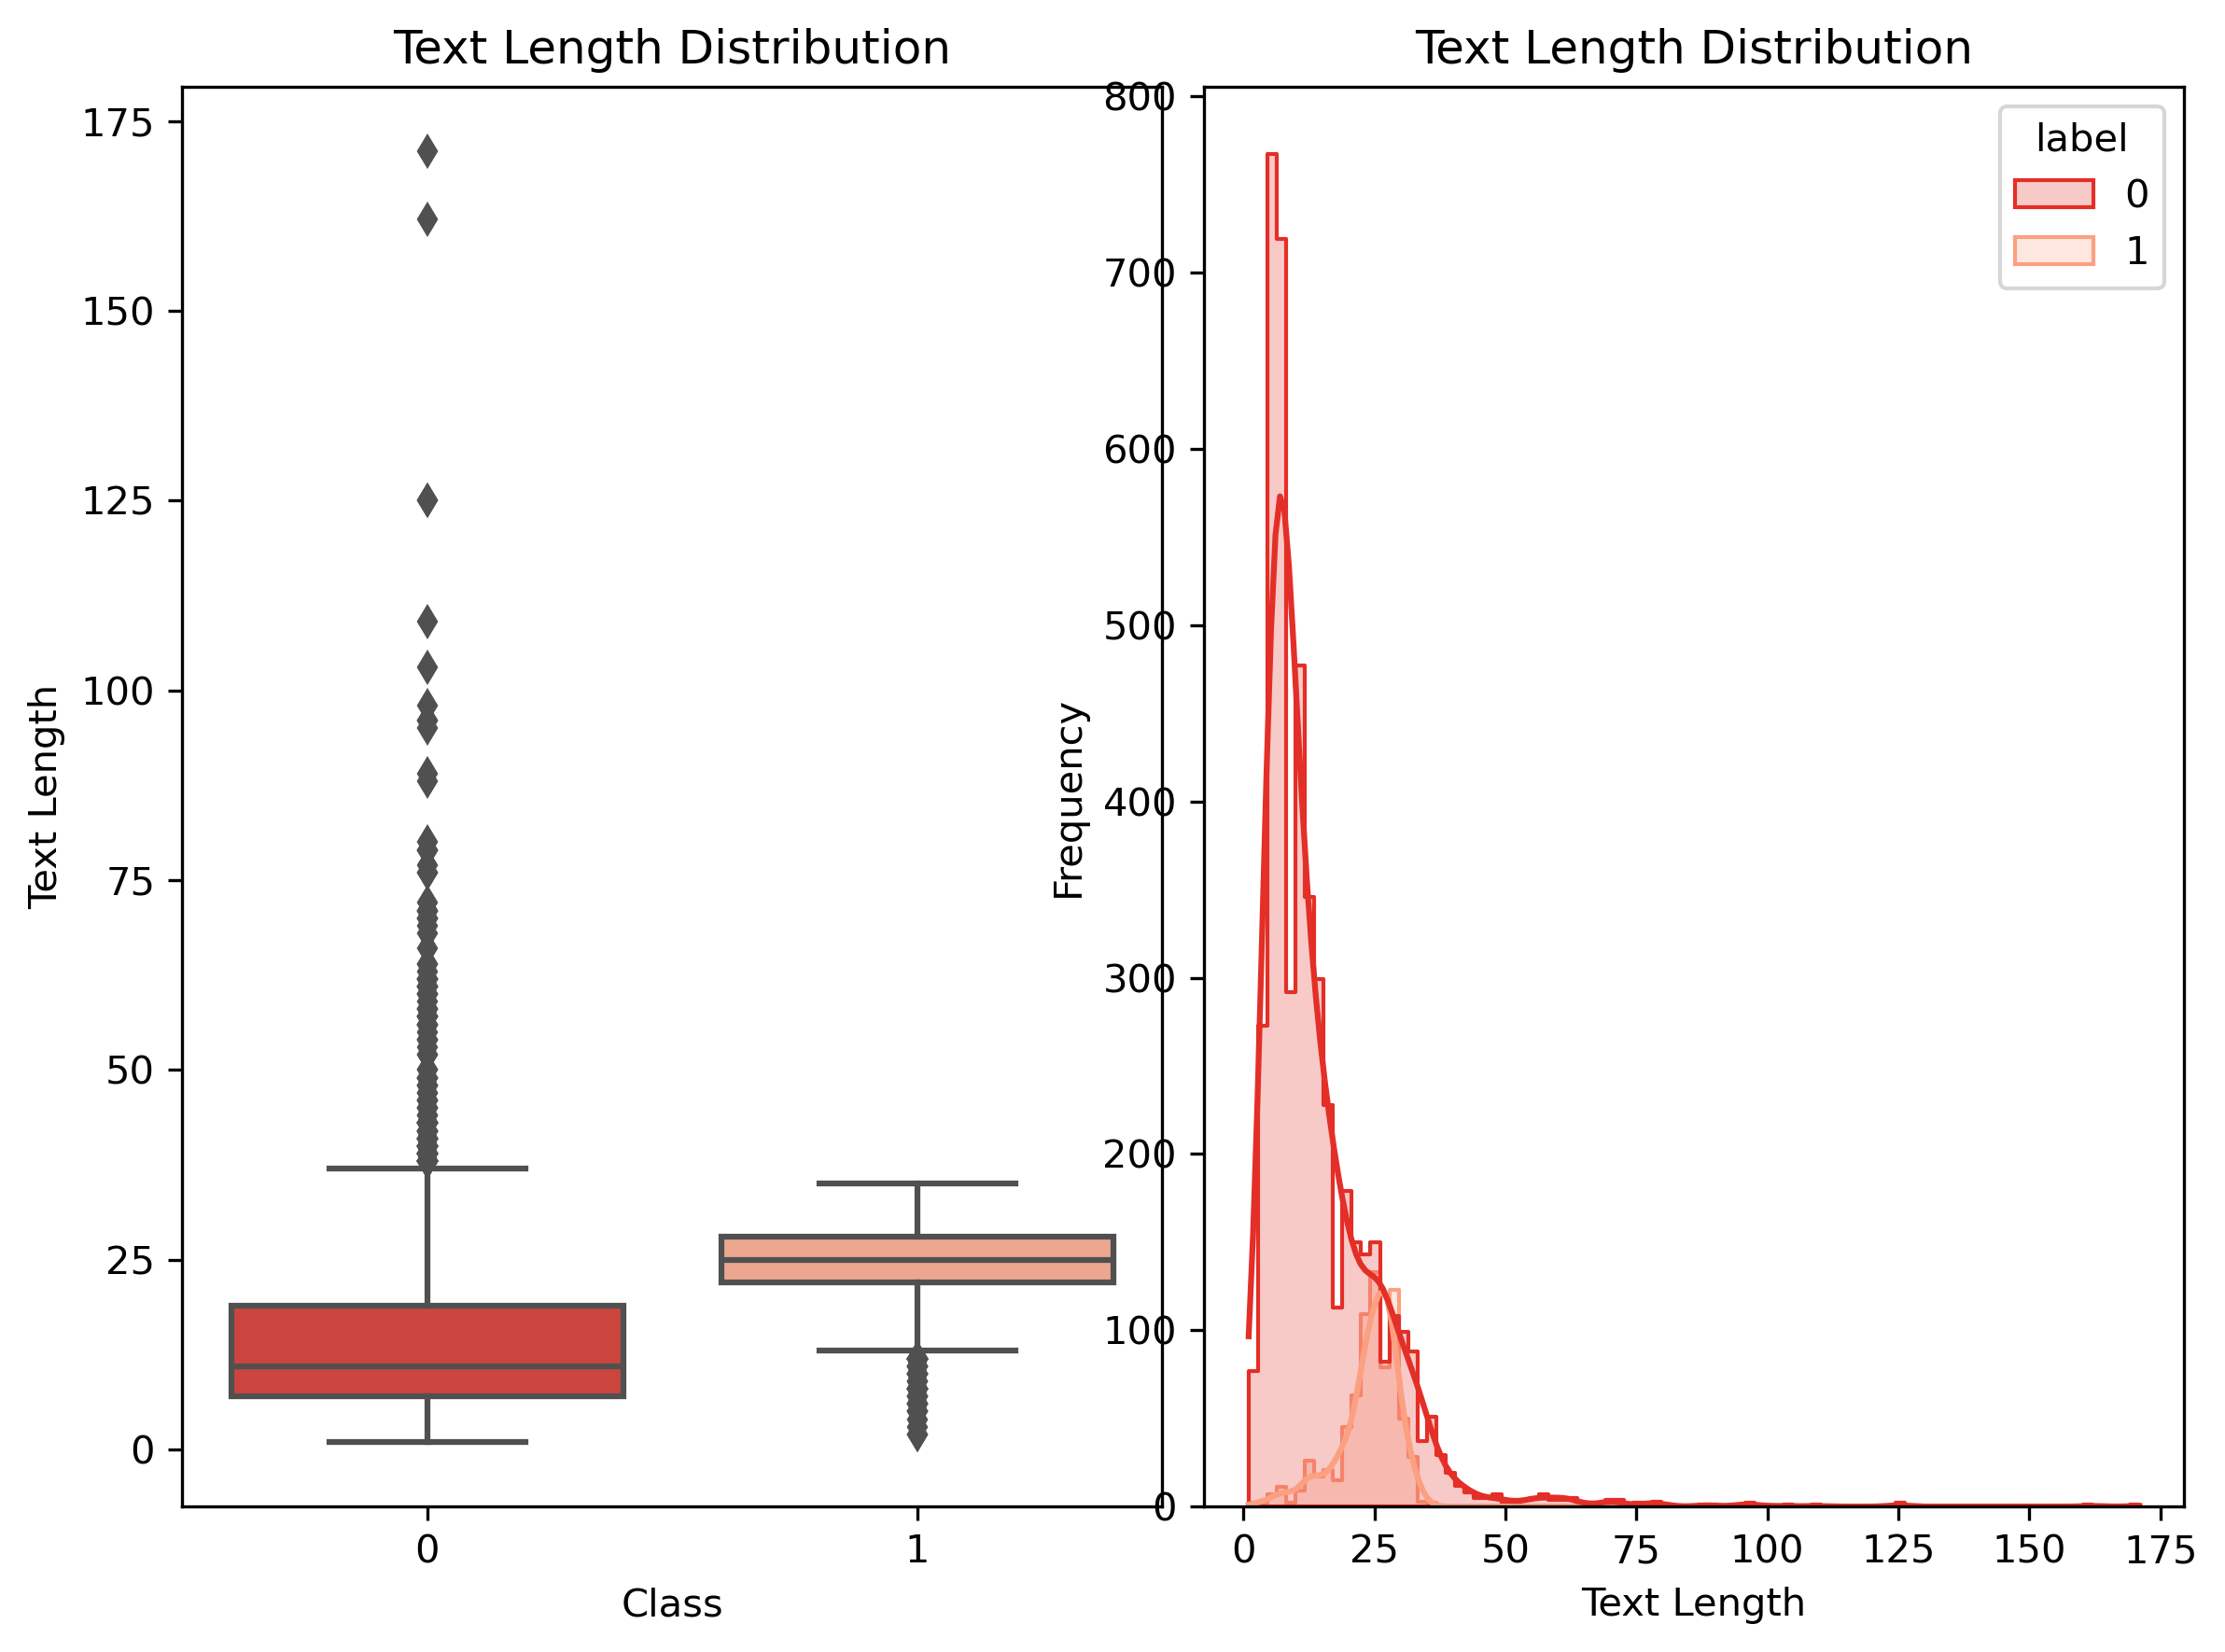

In [32]:
plt.figure(figsize=(8, 6), dpi=300)
plt.subplot(1, 2, 1)
sns.set_palette(colour_palette)

sns.boxplot(x='label', y='text_length', data=data)
plt.title('Text Length Distribution')
plt.xlabel('Class')
plt.ylabel('Text Length')
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.set_palette(colour_palette)
sns.histplot(data=data, x='text_length', hue='label', kde=True, element='step')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Generate the cloud wird for the input text and labels

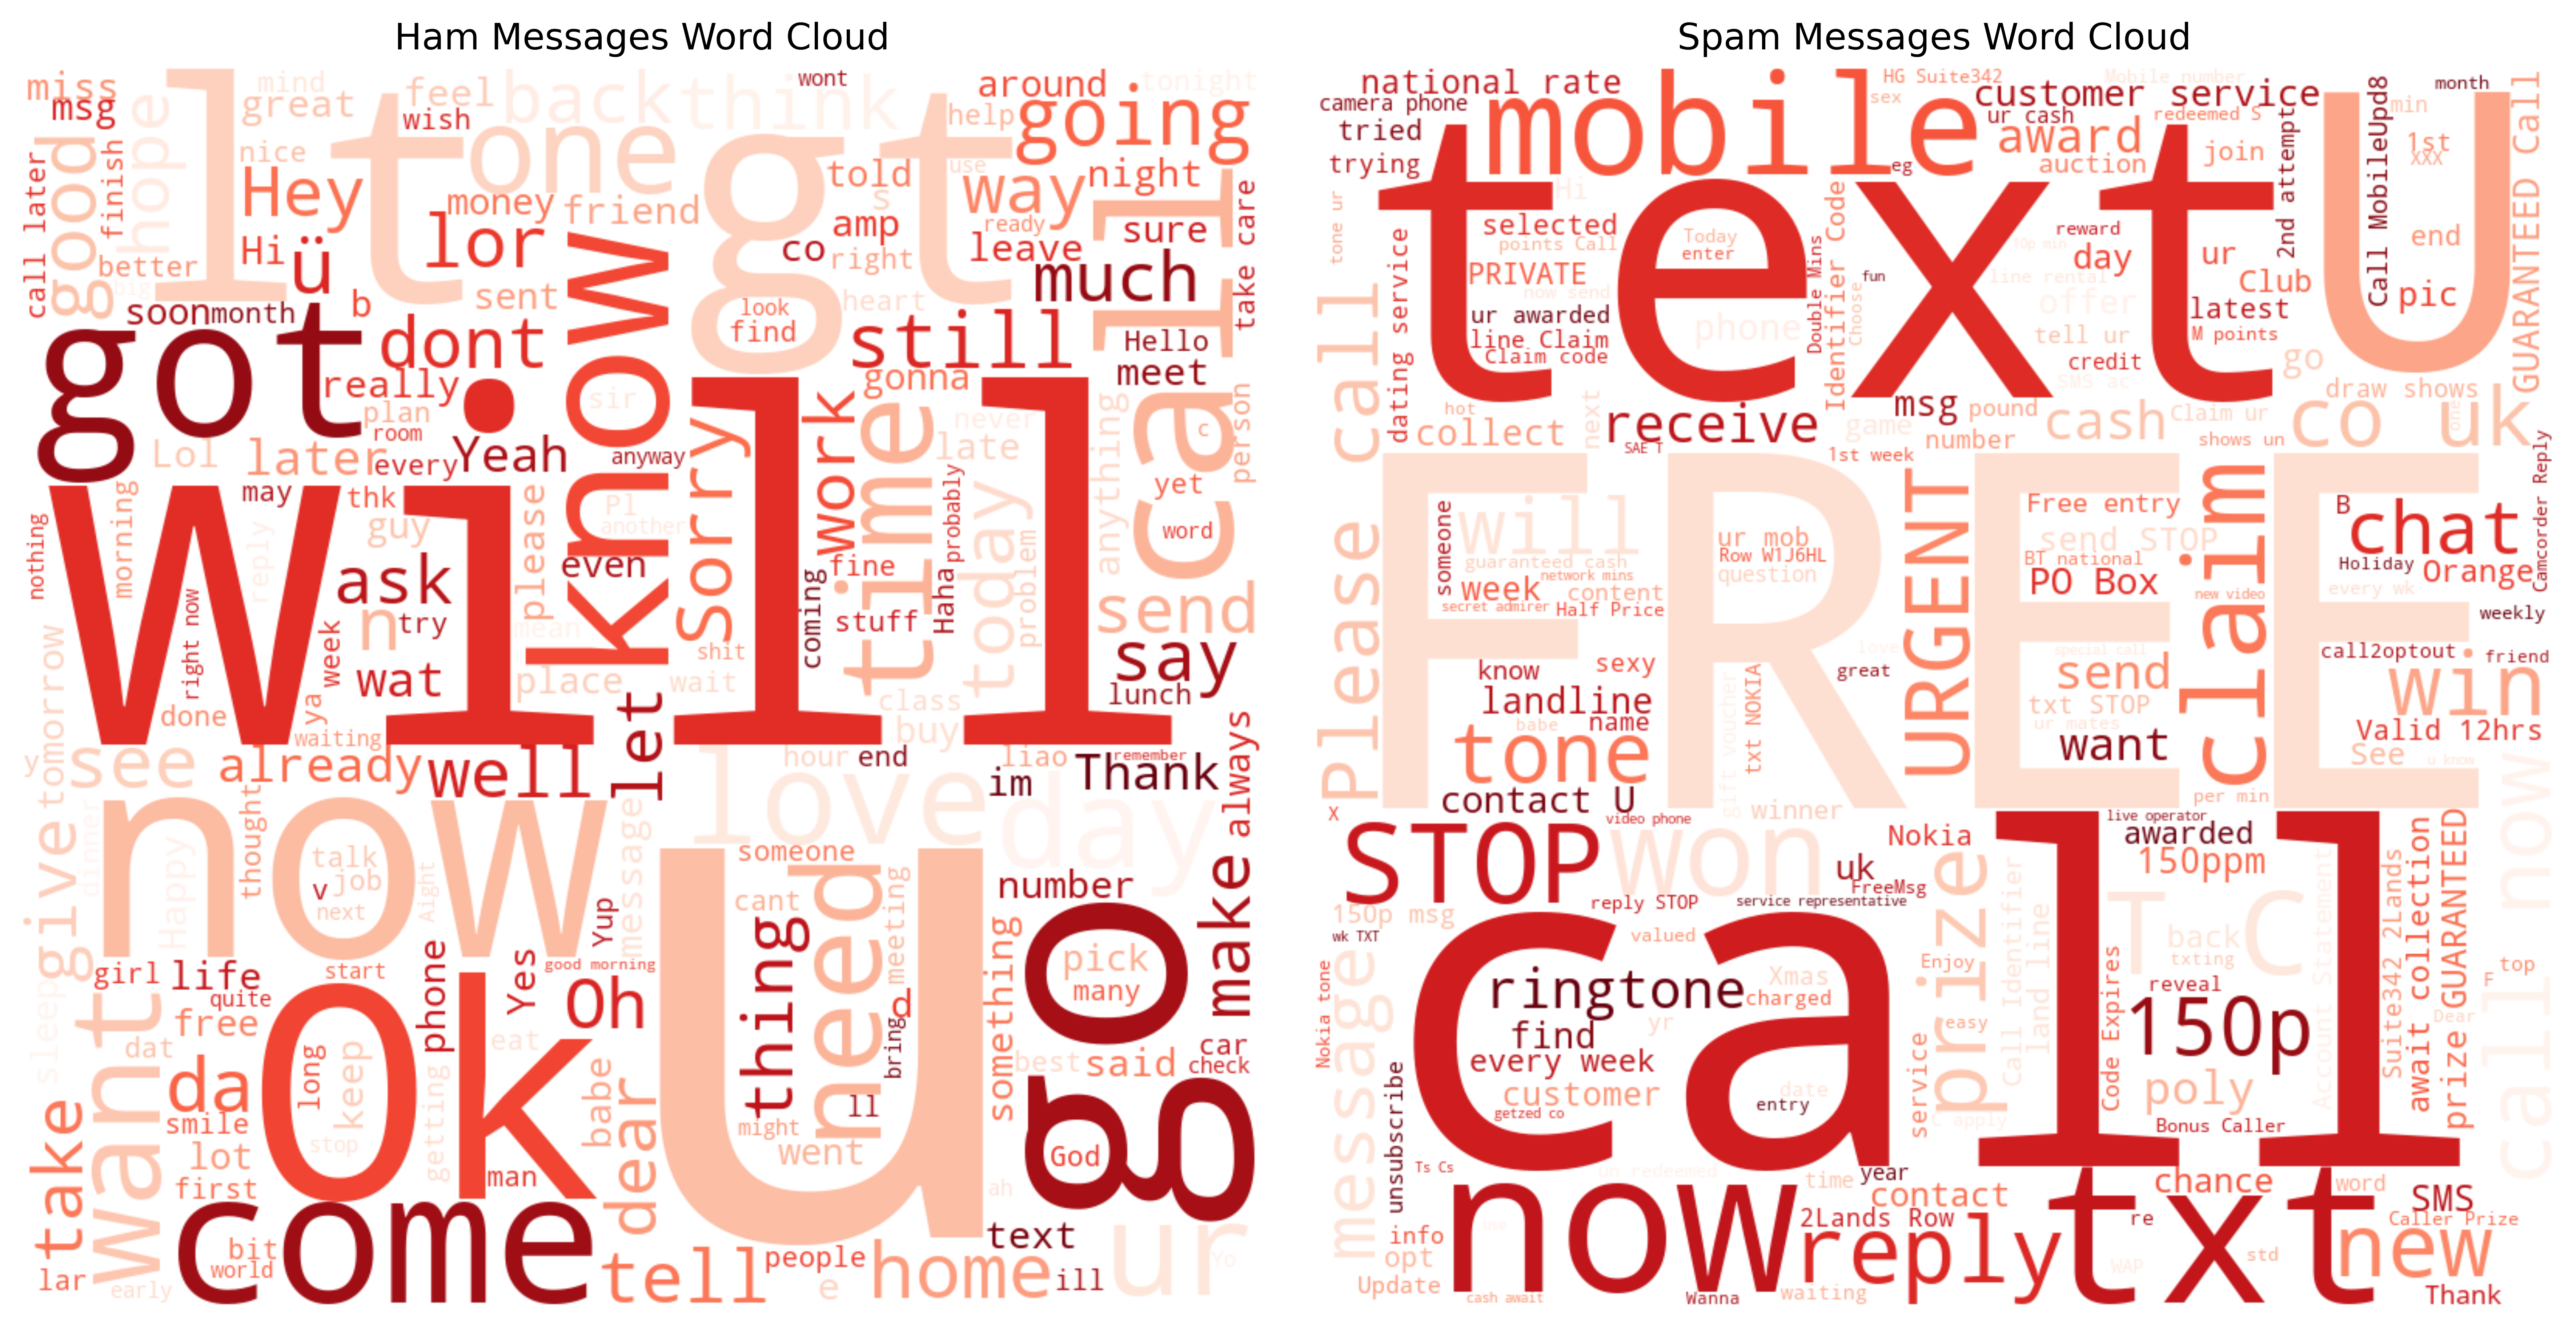

In [33]:
# WORD CLOUD GENERATOR
from wordcloud import WordCloud

ham_text = " ".join(data[data['label'] == 0]['text'])
spam_text = " ".join(data[data['label'] == 1]['text'])

colour_palette_cmap = sns.color_palette("Reds_r", as_cmap=True)
ham_wordcloud = WordCloud(width=800, height=800, background_color='white',
                          colormap=colour_palette_cmap).generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=800, background_color='white',
                           colormap=colour_palette_cmap).generate(spam_text)

ham_image = ham_wordcloud.to_array()
spam_image = spam_wordcloud.to_array()

plt.figure(figsize=(12, 6), dpi=600)

plt.subplot(1, 2, 1)
plt.imshow(ham_image, interpolation='bilinear')
plt.title('Ham Messages Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spam_image, interpolation='bilinear')
plt.title('Spam Messages Word Cloud')
plt.axis('off')

plt.tight_layout()
plt.show()

**TEXT PREPROCESSING WITH NLTK**

Pre-processing the text with
- Tokenization to word with NLTK
- converting all alphanumeric characters in words to lower case
- Lemmatize the words with NLTK
- removing stop words with NLTK

In [34]:

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    #Tokenization
    words = word_tokenize(text)
    #Convert to Lowercase
    words = [word.lower() for word in words if word.isalnum()]
    #Remove Stopwords and then lemmatize
    words = [word for word in words if word not in stopwords.words("english")]
    #Concate tokens back to sentences/text
    return " ".join(words)

In [35]:
text_preproc = pd.DataFrame(data['text'].apply(preprocess_text))

**VECTTORIZATION OF TOKENS**

Convert tokens to vectors using
- TF-IDF
- Bag of Words
- Keras Toeknizer
- Google word2vec/gensim

In [36]:
y = data['label']

In [37]:
# SKLEARN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [38]:
# TF-IDF VECTORIZER
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(2, 2))
X_tfidf = tfidf_vectorizer.fit_transform(text_preproc['text']).toarray()

In [39]:
# BAG OF WORDS
cv=CountVectorizer(max_features=100,binary=True,ngram_range=(2,3))
X_bow=cv.fit_transform(text_preproc['text']).toarray()

In [40]:
# Split to training and test datasets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y,
                                                                 test_size=0.25, random_state=42)

X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y,
                                                                 test_size=0.25, random_state=42)

In [41]:
# FUNCTION TO GENERATE AND PRINT THE METRICS FOR THE TRAINED MODEL

def gen_metrics_of_preds(X_train, y_train,y_test, y_pred, model_name,model):
  print("\n---------------------------------------------------")
  print("---------------------------------------------------")
  print("Generating the metrics for "+model_name)
  print("Accuracy Score of : "+str(accuracy_score(y_test, y_pred)))
  print("Classification Report : ")
  print(classification_report(y_test, y_pred))
  print("Confusion Matrix : ")
  conf_matrix = confusion_matrix(y_test, y_pred)
  print(conf_matrix)
  print("Cross Validation scores : ")
  print(cross_val_score(model, X_train, y_train, cv=4))
  print("---------------------------------------------------")

**TRAIN A KNN CLASSIFIER**

In [42]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

# TRAIN AND TEST WITH TF-IDF VECTORIZED DATA
knn.fit(X_train_tfidf, y_train)
y_pred = knn.predict(X_test_tfidf)
gen_metrics_of_preds(X_train_tfidf, y_train,y_test, y_pred, "KNN Classifier TDIDF",knn)

# TRAIN AND TEST WITH BoW VECTORIZED DATA
knn.fit(X_train_bow, y_train)
y_pred = knn.predict(X_test_bow)
gen_metrics_of_preds(X_train_bow, y_train,y_test, y_pred, "KNN Classifier BoW",knn)


---------------------------------------------------
---------------------------------------------------
Generating the metrics for KNN Classifier TDIDF
Accuracy Score of : 0.9196556671449068
Classification Report : 
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1203
           1       0.95      0.43      0.60       191

    accuracy                           0.92      1394
   macro avg       0.94      0.72      0.78      1394
weighted avg       0.92      0.92      0.91      1394

Confusion Matrix : 
[[1199    4]
 [ 108   83]]
Cross Validation scores : 
[0.91291866 0.92057416 0.91004785 0.90430622]
---------------------------------------------------

---------------------------------------------------
---------------------------------------------------
Generating the metrics for KNN Classifier BoW
Accuracy Score of : 0.9282639885222381
Classification Report : 
              precision    recall  f1-score   support

           0  

**TRAIN A SVM CLASSIFIER**

In [43]:
from sklearn.svm import SVC
svc = SVC(kernel='linear' )

# TRAIN AND TEST WITH TF-IDF VECTORIZED DATA
svc.fit(X_train_tfidf, y_train)
y_pred = svc.predict(X_test_tfidf)
gen_metrics_of_preds(X_train_tfidf, y_train,y_test, y_pred, "SVM Classifier TDIDF",svc)

# TRAIN AND TEST WITH BoW VECTORIZED DATA
svc.fit(X_train_bow, y_train)
y_pred = svc.predict(X_test_bow)
gen_metrics_of_preds(X_train_bow, y_train,y_test, y_pred, "SVM Classifier BoW",svc)


---------------------------------------------------
---------------------------------------------------
Generating the metrics for SVM Classifier TDIDF
Accuracy Score of : 0.9562410329985653
Classification Report : 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1203
           1       0.95      0.72      0.82       191

    accuracy                           0.96      1394
   macro avg       0.95      0.86      0.90      1394
weighted avg       0.96      0.96      0.95      1394

Confusion Matrix : 
[[1196    7]
 [  54  137]]
Cross Validation scores : 
[0.9645933  0.96937799 0.95311005 0.95502392]
---------------------------------------------------

---------------------------------------------------
---------------------------------------------------
Generating the metrics for SVM Classifier BoW
Accuracy Score of : 0.9282639885222381
Classification Report : 
              precision    recall  f1-score   support

           0  